# Semi-Analytic Solutions for Simple Structures

We will calculate deflections, strains, internal forces, stresses and utilizations for a Mindlin plate. We are also going to visualize the stresses using PyVista.

## Simply-Supported Rectangular Plates

In [1]:
from numpy import ascontiguousarray as ascont

from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

size = Lx, Ly = (600.0, 800.0)
E = 2890.0
nu = 0.2
t = 25.0
yield_strength = 25.0

hooke = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)

failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)

material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=t),
    ]
)
ABDS = section.elastic_stiffness_matrix()
D, S = ascont(ABDS[:3, :3]), ascont(ABDS[3:, 3:])

loads = LoadGroup(
    LG1=LoadGroup(
        LC1=RectangleLoad(x=[[0, 0], [Lx, Ly]], v=[-0.1, 0, 0]),
        LC2=RectangleLoad(x=[[Lx / 3, Ly / 2], [Lx / 2, 2 * Ly / 3]], v=[-1, 0, 0]),
    ),
    LG2=LoadGroup(
        LC3=PointLoad(x=[Lx / 3, Ly / 2], v=[-100.0, 0, 0]),
        LC4=PointLoad(x=[2 * Lx / 3, Ly / 2], v=[100.0, 0, 0]),
    ),
)
loads.lock()

shape = nx, ny = (120, 160)
gridparams = {"size": size, "shape": shape, "eshape": "Q4"}
coords, topo = grid(**gridparams)
coords, triangles = Q4_to_T3(coords, topo)
triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]

plate = RectangularPlate(size, (20, 20), D=D, S=S)
results = plate.solve(loads, coords)

f:\GitHub\SigmaEpsilon\sigmaepsilon.solid.material\.solid.material\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## Plotting as a pointcloud

In [2]:
import numpy as np
import pyvista as pv

load_case_results = results["LG1", "LC2"].values
strains = load_case_results[:, 3:8]
z = np.linspace(-t/2, t/2, 20)
rng = (-t/2, t/2)
stresses = section.calculate_stresses(strains=strains, rng=rng, z=z).values
util, util_coords = section.utilization(strains=strains, rng=rng, z=z, coords=coords, return_coords=True)

num_XY, num_Z = util_coords.shape[:2]
util_coords = util_coords.reshape((num_XY * num_Z, 3))
util = util.values.flatten()

point_cloud = pv.PolyData(util_coords)
point_cloud["scalars"] = util

point_cloud

PolyData (0x19a2a50a940)
  N Cells:    389620
  N Points:   389620
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -1.250e+01, 1.250e+01
  N Arrays:   1

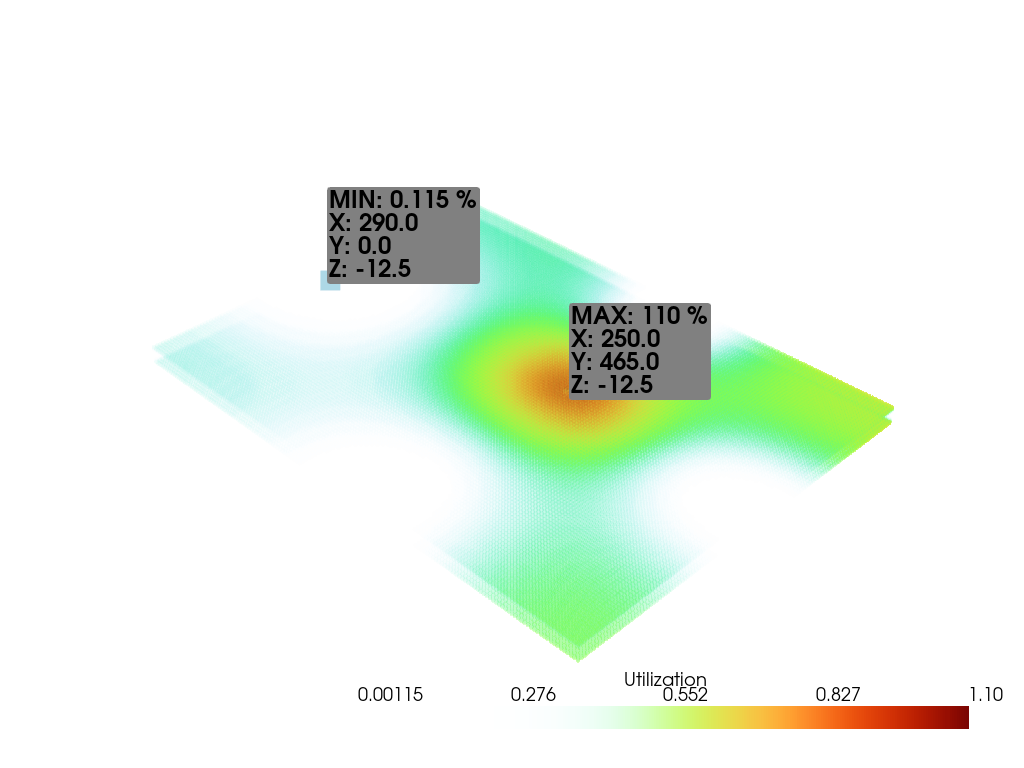

In [3]:
from sigmaepsilon.core.formatting import floatformatter 

formatter = floatformatter(sig=3)

plotter = pv.Plotter(notebook=True)

scalars = util
points = util_coords
max_index = np.argmax(scalars)
min_index = np.argmin(scalars)

p_min = point_cloud.points[min_index]
p_max = point_cloud.points[max_index]
label_coords = np.array([p_min, p_max])

labels = [
    (
        f"MIN: {formatter.format(util.min()*100)} %"
        f"\nX: {points[min_index, 0]}"
        f"\nY: {points[min_index, 1]}"
        f"\nZ: {points[min_index, 2]}"
    ), 
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {points[max_index, 0]}"
        f"\nY: {points[max_index, 1]}"
        f"\nZ: {points[max_index, 2]}"
        )
]

plotter.add_mesh(
    point_cloud,
    scalars='scalars',
    cmap="turbo",
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24, always_visible=True)

plotter.show(jupyter_backend="static")

In [4]:
from sigmaepsilon.mesh import PointData, PolyData, grid, PointCloud
from sigmaepsilon.mesh.cells import H8 as CellData
from sigmaepsilon.mesh.utils import k_nearest_neighbours

coords_h8, topo_h8 = grid(size=(Lx, Ly, t), shape=(nx, ny, 10), eshape="H8")
pc_h8 = PointCloud(coords_h8)
pc_h8.centralize(axes=[2])
coords_h8 = pc_h8.show()
pd_h8 = PointData(coords=coords_h8)
cd_h8 = CellData(topo=topo_h8)
mesh_h8 = PolyData(pd_h8, cd_h8)
centers_h8 = mesh_h8.centers()
nearest_points_indices = k_nearest_neighbours(points, coords_h8)

In [5]:
mesh_h8.points().bounds()

array([[  0. , 600. ],
       [  0. , 800. ],
       [-12.5,  12.5]])

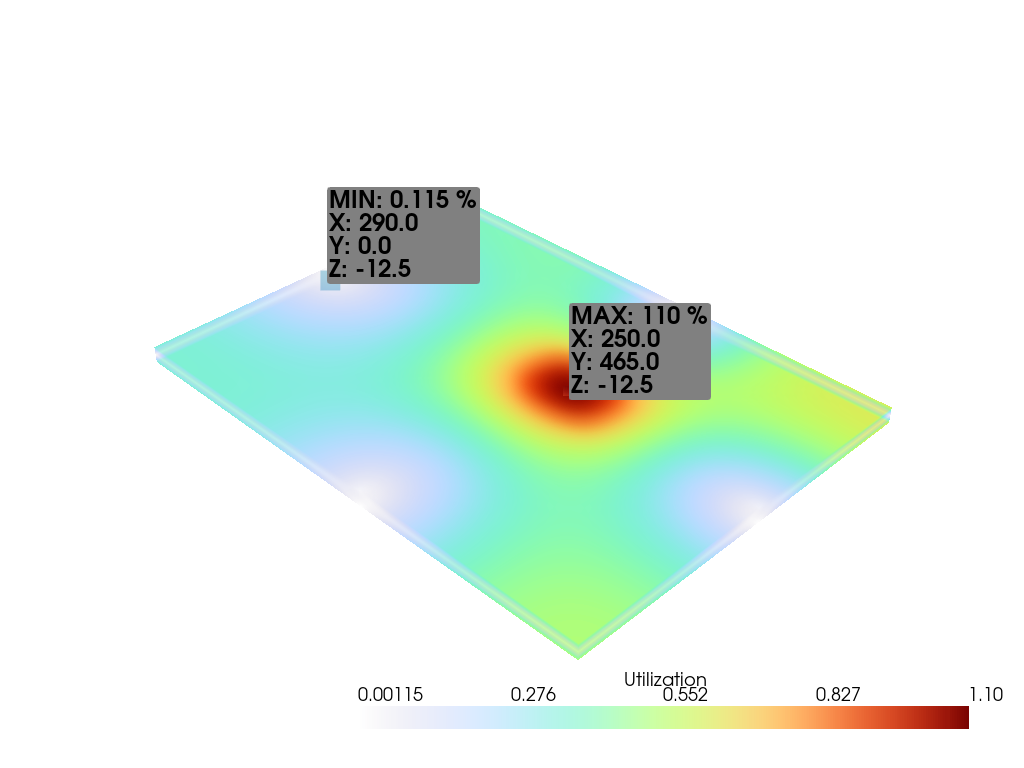

In [6]:
from sigmaepsilon.core.formatting import floatformatter 

formatter = floatformatter(sig=3)

plotter = pv.Plotter(notebook=True)

scalars_h8 = util[nearest_points_indices]
points_h8 = coords_h8
max_index = np.argmax(scalars_h8)
min_index = np.argmin(scalars_h8)

point_min = points_h8[min_index]
point_max = points_h8[max_index]
label_coords = np.array([point_min, point_max])

labels = [
    (
        f"MIN: {formatter.format(util.min()*100)} %"
        f"\nX: {points_h8[min_index, 0]}"
        f"\nY: {points_h8[min_index, 1]}"
        f"\nZ: {points_h8[min_index, 2]}"
    ), 
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {points_h8[max_index, 0]}"
        f"\nY: {points_h8[max_index, 1]}"
        f"\nZ: {points_h8[max_index, 2]}"
        )
]

pvobj = mesh_h8.to_pv()[0]

plotter.add_mesh(
    pvobj,
    scalars=scalars_h8,
    cmap="turbo",
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
    opacity="linear",
)

plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24, always_visible=True)

plotter.show(jupyter_backend="static")

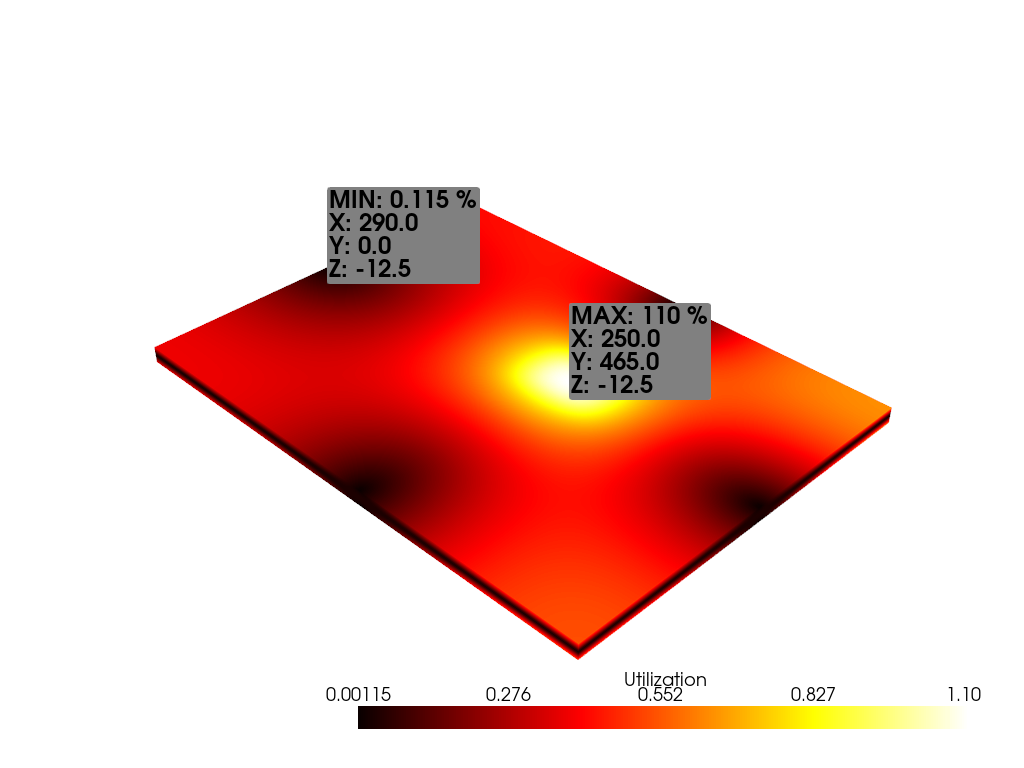

In [7]:
plotter = pv.Plotter(notebook=True)

plotter.add_mesh(
    mesh_h8.to_pv()[0],
    scalars=scalars_h8,
    cmap="hot",
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
)
plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24, always_visible=True)
plotter.show(jupyter_backend="static")

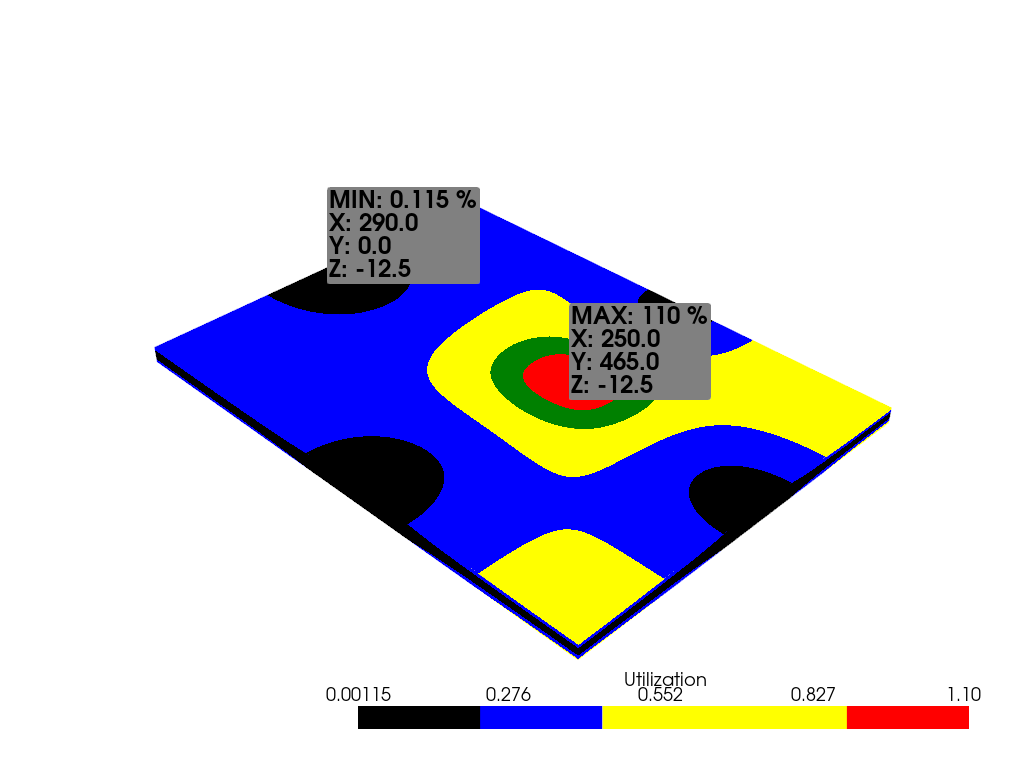

In [8]:
plotter = pv.Plotter(notebook=True)
cmap = ["black", "blue", "yellow", "green", "red"]
plotter.add_mesh(
    mesh_h8.to_pv()[0],
    scalars=scalars_h8,
    cmap=cmap,
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
)
plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24, always_visible=True)
plotter.show(jupyter_backend="static")

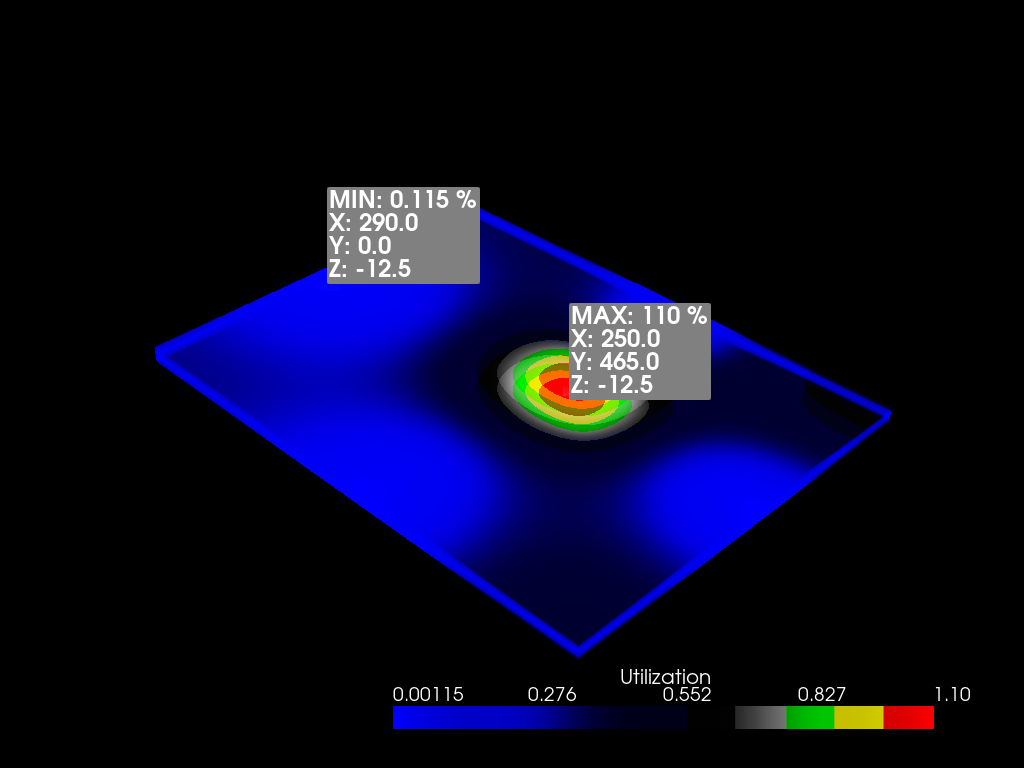

In [9]:
from matplotlib.colors import ListedColormap
from pyvista.plotting.themes import DarkTheme

# Define the colors we want to use
blue = np.array([0, 0, 1, 1.0])
black = np.array([11 / 256, 11 / 256, 11 / 256, 1.0])
green = np.array([0, 1, 0, 1.0])
grey = np.array([189 / 256, 189 / 256, 189 / 256, 1.0])
yellow = np.array([255 / 256, 247 / 256, 0 / 256, 1.0])
red = np.array([1.0, 0.0, 0.0, 1.0])

mapping = np.linspace(scalars_h8.min(), scalars_h8.max(), 256)
newcolors = np.empty((256, 4))
newcolors[:, :] = blue
newcolors[mapping >= 0.6] = black
newcolors[mapping >= 0.7] = grey
newcolors[mapping >= 0.8] = green
newcolors[mapping >= 0.9] = yellow
newcolors[mapping >= 1.0] = red

plotter = pv.Plotter(notebook=True, theme=DarkTheme())
plotter.add_mesh(
    mesh_h8.to_pv()[0],
    scalars=scalars_h8,
    cmap=ListedColormap(newcolors),
    lighting=False,
    scalar_bar_args={'title': "Utilization"},
    opacity=[1.0, 0.8, 0.7, 0.2, 0.1, 0.2, 0.7, 0.8, 1.0],
    show_edges=False,
)
plotter.add_point_labels(label_coords, labels, point_size=20, font_size=24, always_visible=True)
plotter.show(jupyter_backend="static")

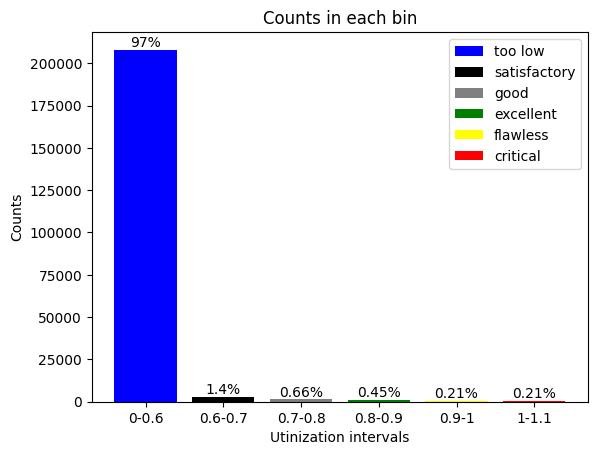

In [17]:
import numpy as np
import matplotlib.pyplot as plt

formatter = floatformatter(sig=2)

# Define boundaries
boundaries = [0.0, 0.6, 0.7, 0.8, 0.9, 1.0]
if scalars_h8.max() > 1.0:
    boundaries.append(scalars_h8.max())

# Calculate the count of values in each bin
counts, _ = np.histogram(scalars_h8, bins=boundaries)

bar_labels = [
    "too low",
    "satisfactory",
    "good",
    "excellent",
    "flawless",
    "critical",
]
bar_colors = ["blue", "black", "grey", "green", "yellow", "red"]

# Plotting
tick_label = [
    f"{formatter.format(boundaries[i])}-{formatter.format(boundaries[i+1])}"
    for i in range(len(boundaries) - 1)
]
bars = plt.bar(
    range(len(counts)),
    counts,
    tick_label=tick_label,
    color=bar_colors,
    label=bar_labels,
)

num_data = len(scalars_h8)
bar_percentages = [100 * x / num_data for x in counts]

for bar, perc in zip(bars, bar_percentages):
    yval = bar.get_height()
    bar_str = f"{formatter.format(perc)}%"
    plt.text(bar.get_x() + bar.get_width() / 2, yval, bar_str, ha="center", va="bottom")


plt.xlabel("Utinization intervals")
plt.ylabel("Counts")
plt.title("Counts in each bin")
plt.legend()
plt.show()